# Ambulance Routing Ithaca Dataset

One potential application of reinforcement learning involves positioning a server or servers (in this case an ambulance) in an optimal way geographically to respond to incoming calls while minimizing the distance traveled by the servers. This is closely related to the [k-server problem](https://en.wikipedia.org/wiki/K-server_problem), where there are $k$ servers stationed in a space that must respond to requests arriving in that space in such a way as to minimize the total distance traveled. 

The ambulance routing problem addresses the problem by modeling an environment where there are ambulances stationed at locations, and calls come in that one of the ambulances must be sent to respond to. The goal of the agent is to minimize both the distance traveled by the ambulances between calls and the distance traveled to respond to a call by optimally choosing the locations to station the ambulances. The ambulance environment has been implemented in two different ways; as a 1-dimensional number line $[0,1]$ along which ambulances will be stationed and calls will arrive, and a graph with nodes where ambulances can be stationed and calls can arrive, and edges between the nodes that ambulances travel along.


In this notebook, we walk through the Ambulance Routing problem with on a graph. There is a structured as a graph of nodes $V$ with edges between the nodes $E$. Each node represents a location where an ambulance could be stationed or a call could come in. The edges between nodes are undirected and have a weight representing the distance between those two nodes.

The nearest ambulance to a call is determined by computing the shortest path from each ambulance to the call, and choosing the ambulance with the minimum length path. The calls arrive using a prespecified iid probability distribution. The default is for the probability of call arrivals to be evenly distributed over all the nodes; however, the user can also choose different probabilities for each of the nodes that a call will arrive at that node. For example, in the following graph the default setting would be for each call to have a 0.25 probability of arriving at each node, but the user could instead specify that there is a 0.1 probability of a call at node 0, and a 0.3 probability of a call arriving at each of the other three nodes.


We do a single experiment using the underlying graph taken as the Ithaca city, with arrivals from a historical police call dataset.
This is an example with 2 ambulances (k=2) at nodes 2 and 3. 

![Graph_Diagram](diagrams/final_graph_ithaca.png)


A call can come from any random node and ambulance that has the shortest distance shown here with the edges, responds to the call. 

Below is an example of this probelm on a numberline with ambulances at points 0.4 and 0.6. 

![Metric_Picture](diagrams/metric_pic.png)


### Package Installation


In [1]:
import or_suite
import numpy as np

import copy

import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd


import gym

### Experimental Parameters

The ambulance routing problem has several experiment parameters
* The parameter `epLen`, an int, represents the length of each episode 
* `nEps` is an int representing the number of episodes. The default is set to 2. 
* `numIters`, an int, is the number of iterations. Here it is set to 50. 
* `seed` allows random numbers to be generated. 
* `dirPath`, a string, is the location where the data files are stored.
* `deBug`, a bool, prints information to the command line when set true. 
* `save_trajectory`, a bool, saves the trajectory information of the ambulance when set to true. 
* `render` renders the algorithm when set to true.
* `pickle` is a bool that saves the information to a pickle file when set to true.

Along with experiment parameters, the ambulance problem has several environmental parameters.
* `alpha`, a float controlling the proportional difference between the cost to move ambulances in between calls and the cost to move the ambulance to respond to a call. If `alpha` is 0, there is no cost to move between calls. If `alpha` is one, there is no cost to respond to calls.
* `num_ambulance`, an int which represents the number of ambulances in the system. 


In [2]:

# Getting out configuration parameter for the environment
CONFIG =  or_suite.envs.env_configs.ambulance_graph_ithaca_config


# Specifying training iteration, epLen, number of episodes, and number of iterations
epLen = CONFIG['epLen']
nEps = 1
numIters = 2



# Configuration parameters for running the experiment
DEFAULT_SETTINGS = {'seed': 1, 
                    'recFreq': 1, 
                    'dirPath': '../data/ambulance/', 
                    'deBug': False, 
                    'nEps': nEps, 
                    'numIters': numIters, 
                    'saveTrajectory': True, # save trajectory for calculating additional metrics
                    'epLen' : 5,
                    'render': False,
                    'pickle': False # indicator for pickling final information
                    }


alpha = CONFIG['alpha']
num_ambulance = CONFIG['num_ambulance']

ambulance_env = gym.make('Ambulance-v1', config=CONFIG)
mon_env = Monitor(ambulance_env)


### Specifying Agent
We have several heuristics implemented for each of the environments defined, in addition to a `Random` policy, and some `RL discretization based` algorithms. 

The `Stable` agent only moves ambulances when responding to an incoming call and not in between calls. This means the policy $\pi$ chosen by the agent for any given state $X$ will be $\pi_h(X) = X$

The `Median` agent takes a list of all past call arrivals sorted by arrival location, and partitions it into $k$ quantiles where $k$ is the number of ambulances. The algorithm then selects the middle data point in each quantile as the locations to station the ambulances.

The `Mode` agent chooses to stattion the ambulances at the nodes where the most calls have come in the past. This uses the policy $\pi$ chosen by a state $X$ will be $\pi_h(X) = $`mode` 


In [3]:
agents = { 'SB PPO': PPO(MlpPolicy, mon_env, gamma=1, verbose=0, n_steps=epLen),
'Random': or_suite.agents.rl.random.randomAgent(),
'Stable': or_suite.agents.ambulance.stable.stableAgent(CONFIG['epLen']),
'Mode': or_suite.agents.ambulance.mode_graph.modeAgent(CONFIG['epLen']),
'Median': or_suite.agents.ambulance.median_graph.medianAgent(CONFIG['epLen'], CONFIG['edges'], CONFIG['num_ambulance']),
}

/home/sean/anaconda3/envs/ORSuite/lib/python3.7/site-packages/stable_baselines3/ppo/ppo.py:138: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 5`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 5
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=5 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Run the different heuristics in the environment

### Running Algorithm


SB PPO
Writing to file ../data/ambulance_metric_SB PPO_2_0.25/data.csv
Random
Writing to file data.csv
Stable
Writing to file data.csv
Mode
Writing to file data.csv
Median
Writing to file data.csv
  Algorithm    Reward      Time    Space
0    Random -526.6625  4.203370 -10163.5
1    Stable -491.1750  4.990375  -5213.5
2      Mode -474.0875  4.795125  -7132.0
3    Median -404.1125  4.068685  -5903.5


FileNotFoundError: [Errno 2] No such file or directory: ''

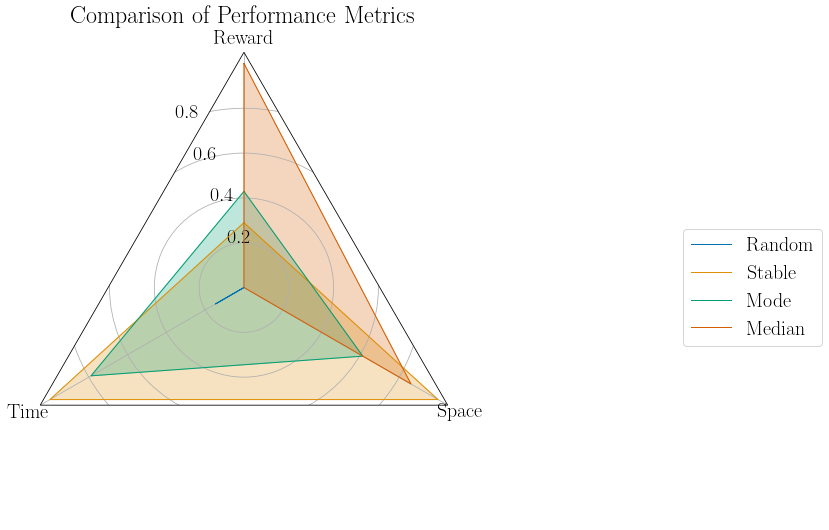

In [4]:
path_list_line = []
algo_list_line = []
path_list_radar = []
algo_list_radar= []
for agent in agents:
    print(agent)
    DEFAULT_SETTINGS['dirPath'] = '../data/ambulance_metric_'+str(agent)+'_'+str(num_ambulance)+'_'+str(alpha)+'/'
    if agent == 'SB PPO':
        or_suite.utils.run_single_sb_algo(mon_env, agents[agent], DEFAULT_SETTINGS)
    elif agent == 'AdaQL' or agent == 'Unif QL' or agent == 'AdaMB' or agent == 'Unif MB':
        or_suite.utils.run_single_algo_tune(ambulance_env, agents[agent], scaling_list, DEFAULT_SETTINGS)
    else:
        or_suite.utils.run_single_algo(ambulance_env, agents[agent], DEFAULT_SETTINGS)

    path_list_line.append('../data/ambulance_metric_'+str(agent)+'_'+str(num_ambulance)+'_'+str(alpha))
    algo_list_line.append(str(agent))
    if agent != 'SB PPO':
        path_list_radar.append('../data/ambulance_metric_'+str(agent)+'_'+str(num_ambulance)+'_'+str(alpha))
        algo_list_radar.append(str(agent))
fig_path = '../figures/'
fig_name = 'ambulance_metric'+'_'+str(num_ambulance)+'_'+str(alpha)+'_line_plot'+'.pdf'
or_suite.plots.plot_line_plots(path_list_line, algo_list_line, fig_path, fig_name, int(nEps / 40)+1)

additional_metric = {}
fig_name = 'ambulance_metric'+'_'+str(num_ambulance)+'_'+str(alpha)+'_radar_plot'+'.pdf'
or_suite.plots.plot_radar_plots(path_list_radar, algo_list_radar,
fig_path, fig_name,
additional_metric
)


Here we see with a quick set-up that the best-performing algorithm in this limited data regime is the Mode algorithm, essentially putting the ambulances at the estimated mode from the observed data thus far.